In [17]:
### import all used libraries

from sklearn.metrics.pairwise import polynomial_kernel,rbf_kernel,sigmoid_kernel
from sklearn.metrics.pairwise import additive_chi2_kernel,chi2_kernel,cosine_similarity
from sklearn.metrics.pairwise import cosine_distances,euclidean_distances,haversine_distances
from sklearn.metrics.pairwise import laplacian_kernel,manhattan_distances
import numpy as np
import glob
import pickle as pk
from sklearn.preprocessing import MinMaxScaler,StandardScaler,PolynomialFeatures
import sys
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

In [2]:
### creates a dictionary for the divisions

# define the paths into the container
data_path  = 'data/prob-reductions/*'

# create a list of config files

file_list  = glob.glob(data_path)

# creating data divisions dictionary

divisions_dict = {}

# getting number of divisions

n_elements = len(file_list)

print('Reading reductions...')

for i,file_name in enumerate(file_list):

    with open(file_name, 'rb') as f:
        seed = pk.load(f)

    divisions_dict[i] = seed

    # updating progress bar

    percent = (i+1)/n_elements * 100

    info = '{:.2f}% - {:d} of {:d}'.format(percent,(i+1),n_elements)

    formated_bar = '-'*int(percent) + ' '*int(100-percent)

    if i < (n_elements):
        sys.stdout.write("\r")

    sys.stdout.write('[%s] %s' % (formated_bar,info))
    sys.stdout.flush()


Reading reductions...
[----------------------------------------------------------------------------------------------------] 100.00% - 1 of 1

In [20]:
### definig set of parameters to study

# defining attributes to use

att_list = [3,10,14,15,16,17,18]

# defining list of metrics

metrics = [
    additive_chi2_kernel,
    chi2_kernel,
    cosine_similarity,
    cosine_distances,
    euclidean_distances,
#    haversine_distances,
    laplacian_kernel,
    manhattan_distances,
    polynomial_kernel,
    rbf_kernel,
    sigmoid_kernel,
]

names = [
    'additive chi-squared',
    'exponential chi-squared',
    'cosine similarity',
    'cosine distance',
    'Euclidean distance',
#    'Haversine distance',
    'laplacian kernel',
    'L1 distance',
    'polynomial kernel',
    'rbf (gaussian) kernel',
    'sigmoid'

]

In [22]:
### calculing pairrwise metrics

metrics_dict = {}


for reduction in divisions_dict:

    # Reading data and label

    data = divisions_dict[reduction]['df'].values

    data = data[:,att_list]

    y = divisions_dict[reduction]['labels']


    # Separrating signal from background

    background = data[y==0]
    
    signal = data[y==1]


    ### computing pairwise metrrics

    metrics_dict[reduction] = {}

    # getting number of divisions

    n_elements = len(data)*len(metrics)

    k = 0


    print('Calculating pairwise metrics...')

    for name,metric in zip(names,metrics):

        metrics_dict[reduction][name] = {
            'pairwise_score' : {
                'general' : {
                    'cumulative_prox' : []
                },
                'signal_signal' : {
                    'cumulative_prox' : [],
                    'mean_prox' : [],
                    'std_prox' : []
                },
                'signal_background' : {
                    'cumulative_prox' : [],
                    'mean_prox' : [],
                    'std_prox' : []
                }
            }
        }


        for i in range(len(data)):


            # Calculates the metric for all samples

            line = data[i].reshape(1, -1)
            
            score = metric(line,data[:])


            # compute the distance sum, mean and std between background and signal samples

            dist_sum = np.sum(score**2)


            # concatenating results

            metrics_dict[reduction][name]['pairwise_score']['general']['cumulative_prox'].append(dist_sum)

            if i < 500:

                # Calculates signal-signal metrics

                line = signal[i].reshape(1, -1)
                
                score = metric(line,signal[:])
            

                # compute the distance sum, mean and std between background and signal samples

                dist_sum = np.sum(score**2)

                dsit_mean = np.mean(score)

                dsit_std = np.std(score)


                # concatenating results

                metrics_dict[reduction][name]['pairwise_score']['signal_signal']['cumulative_prox'].append(dist_sum)

                metrics_dict[reduction][name]['pairwise_score']['signal_signal']['mean_prox'].append(dsit_mean)

                metrics_dict[reduction][name]['pairwise_score']['signal_signal']['std_prox'].append(dsit_std)


                # Calculates signal-background metrics

                line = signal[i].reshape(1, -1)
                
                score = metric(line,background[:])


                # compute the distance sum, mean and std between background and signal samples

                dist_sum = np.sum(score**2)
                
                dsit_mean = np.mean(score)

                dsit_std = np.std(score)


                # concatenating results

                metrics_dict[reduction][name]['pairwise_score']['signal_background']['cumulative_prox'].append(dist_sum)

                metrics_dict[reduction][name]['pairwise_score']['signal_background']['mean_prox'].append(dsit_mean)

                metrics_dict[reduction][name]['pairwise_score']['signal_background']['std_prox'].append(dsit_std)


            # updating progress bar

            k += 1

            percent = (k)/n_elements * 100/2

            info = '{:.2f}% - {:d} of {:d}'.format(percent*2,(k),n_elements)

            formated_bar = '-'*int(percent) + ' '*int(50-percent)

            if i < (n_elements):

                sys.stdout.write("\r")

            sys.stdout.write('[%s] %s' % (formated_bar,info))

            sys.stdout.flush()
        
    sys.stdout.write("\r")

    print('Calculation complete!\n')


Calculating pairwise metrics...
[----------------------                           ] 45.45% - 250000 of 550000

ValueError: Haversine distance only valid in 2 dimensions

In [12]:
### normalizing metrics



{'cumulative_prox': [250422.76147594323,
  254886.2505109139,
  248481.53647927678,
  255955.66401902918,
  247844.4311993674,
  251548.57314289754,
  249605.47934023963,
  243958.94286815793,
  249152.30981377646,
  249612.28234462914,
  255920.69809098283,
  249963.87524446,
  250040.7280895292,
  247070.03169185793,
  248017.065372094,
  253058.65410310088,
  252149.56466041633,
  249806.41177345085,
  245402.70089297154,
  249212.49531982717,
  261846.62694909063,
  257786.26027039695,
  248919.27688581712,
  253921.64676667104,
  252636.60916639943,
  254583.7490145165,
  254247.3476611295,
  245584.31937201353,
  250030.79408319687,
  250329.53797989796,
  251026.66393190698,
  244664.74917176145,
  262055.83519921228,
  250959.30300030782,
  242592.2855671267,
  246355.56896392757,
  246879.75145305996,
  249946.2924489291,
  256035.08582864207,
  247047.20225145662,
  246568.05639650862,
  256800.6884266489,
  246434.73377043693,
  254661.61274303333,
  259991.1327105063,
  264

In [9]:
### calculating densities

sum_args = [0,1,4]

for reduction in metrics_dict:

    # Reading data and label

    data = metrics_dict[reduction]['pairwise_score']

    data = data[:,sum_args]

    y = divisions_dict[reduction]['labels']


    # Separrating signal from background

    background = data[y==0]
    
    signal = data[y==1]


    ### computing pairwise metrrics

    metrics_dict[reduction]['local_density']= {

        'general_density' : [],

        'bg_bg_density' : [],

        'bg_sg_density' : [],

        'sg_sg_density' : [],

        'sg_bg_density' : [],
    }

    # getting number of divisions

    n_elements = len(data)


    # creating density matrice
    

    print('Calculating pairwise metrics...')


    for i in range(len(data)):

        # calculating general density

        sample = data[i,0]

        local_density = np.sum(data[:,0])/(2*n_elements*sample)

        metrics_dict[reduction]['local_density']['general_density'].append(local_density)

        
        # calculating background-background density

        sample = background[i,1]

        local_density = np.sum(background[:,1])/(2*n_elements*sample)

        metrics_dict[reduction]['local_density']['bg_bg_density'].append(local_density)

        
        # calculating background-signal density

        sample = background[i,2]

        local_density = np.sum(background[:,2])/(2*n_elements*sample)

        metrics_dict[reduction]['local_density']['bg_sg_density'].append(local_density)


        # calculating signal-signal density

        sample = signal[i,2]

        local_density = np.sum(signal[:,2])/(2*n_elements*sample)

        metrics_dict[reduction]['local_density']['sg_sg_density'].append(local_density)


        # calculating signal-background density

        sample = signal[i,1]

        local_density = np.sum(signal[:,1])/(2*n_elements*sample)

        metrics_dict[reduction]['local_density']['sg_bg_density'].append(local_density)


        # updating progress bar

        percent = (i+1)/n_elements * 100/2

        info = '{:.2f}% - {:d} of {:d}'.format(percent*2,(i+1),n_elements)

        formated_bar = '-'*int(percent) + ' '*int(50-percent)

        if i < (n_elements):

            sys.stdout.write("\r")

            sys.stdout.write('[%s] %s' % (formated_bar,info))

            sys.stdout.flush()
    
    sys.stdout.write("\r")


TypeError: list indices must be integers or slices, not tuple

# Important

In [14]:
### computing pairwise metrrics

pairwise = []


# getting number of divisions

n_elements = len(signal_train)


print('Calculating pairwise metrics...')


for i in range(len(signal_train)):

    # Compute the polynomial kernel

    line = signal_train[i]

    aux = polynomial_kernel(line,data[:])


    # compute the distance mean and std between background and signal samples

    background_mean_dist = np.mean(aux[0,y==0])

    background_std_dist = np.std(aux[0,y==0])

    signal_mean_dist = np.mean(aux[0,y==1])

    signal_std_dist = np.std(aux[0,y==1])

    result = np.array([background_mean_dist,
                    background_std_dist,
                    signal_mean_dist,
                    signal_std_dist])

    pairwise.append(result)
    

    # updating progress bar

    percent = (i+1)/n_elements * 100

    info = '{:.2f}% - {:d} of {:d}'.format(percent,(i+1),n_elements)

    formated_bar = '-'*int(percent) + ' '*int(100-percent)

    if i < (n_elements):
        sys.stdout.write("\r")

    sys.stdout.write('[%s] %s' % (formated_bar,info))
    sys.stdout.flush()

Calculating pairwise metrics...
[----------------------------------------------------------------------------------------------------] 100.00% - 100000 of 100000

In [15]:
pairwise = np.array(pairwise)

pairwise.shape

(100000, 4)

In [16]:
attributes = ['background mean',
            'background std',
            'signal mean',
            'signal std']

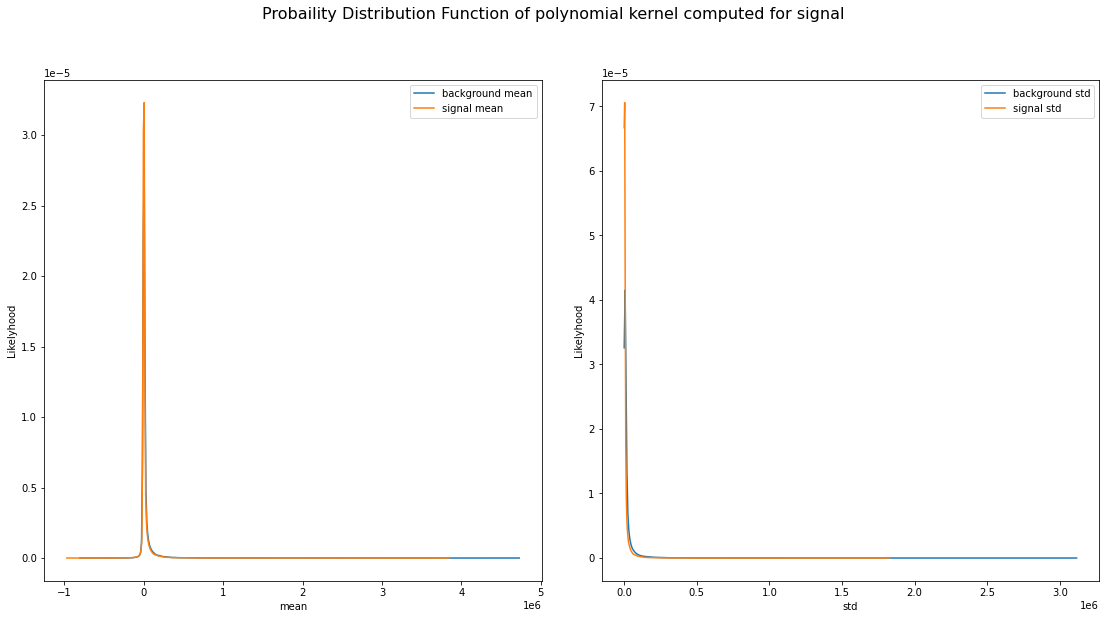

In [18]:
size_scaler = 1

fig = plt.figure(figsize= (16 * size_scaler, 9 * size_scaler))

ax = fig.subplots(1,2)

fig.suptitle('Probaility Distribution Function of polynomial kernel computed for signal', fontsize=16)

for i,att in enumerate(attributes):

        # getting attributes values

        att_background = pairwise[:,i]


        # computing the attribute distribution

        bg_kernel = stats.gaussian_kde(att_background)


        # defining attributes limits

        bg_max = max(att_background)

        bg_min = min(att_background)


        # creating values interval for time optimization

        bg_eval = np.linspace(bg_min,bg_max,num=500)


        # calculating the likelyhood with kde kernel

        bg_likelyhood = bg_kernel(bg_eval)


        # defining plot locationg

        col = int(i%2)

        # defining label

        if col == 0: x_label = 'mean'

        else: x_label = 'std'

        # ploting results

        ax[col].plot(bg_eval, bg_likelyhood, 
                ms=3.5, linestyle='-',
                label= att)

        ax[col].legend()
        ax[col].set_xlabel(x_label)
        ax[col].set_ylabel("Likelyhood")
        ax[col].grid()


fig.tight_layout(pad=3.0)

plt.savefig('figures/polynomial-kernel-PDF.pdf',format='pdf')

del fig